# Notebook 05: Modelado Predictivo

**Objetivo:** Entrenar un modelo de Machine Learning capaz de predecir el consumo eléctrico mensual por comuna, basándose en variables climáticas, socioeconómicas y temporales.

**Estrategia:**
1. **Split Temporal:** Entrenar con datos hasta 2022, testear con 2023 en adelante. Prohibido mirar el futuro.
2. **Modelo:** Usaremos **XGBoost** (o Random Forest), ya que maneja bien la no-linealidad del clima (la "curva en U" del consumo) y las interacciones complejas entre ingresos y temperatura.
3. **Evaluación:** Usaremos MAE (Error Absoluto Medio) para saber cuántos kWh nos equivocamos en promedio, y R2 para ver qué tan bien explicamos la varianza.

**Input:** `data/processed/master_table.csv`

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
# Si tienes xgboost instalado, úsalo. Si no, RandomForest es un buen backup.
try:
    from xgboost import XGBRegressor
    MODEL_TYPE = 'XGBoost'
except ImportError:
    MODEL_TYPE = 'RandomForest'

# --- CONFIGURACIÓN ---
DATA_PATH = os.path.join('..', 'data', 'processed', 'master_table.csv')
sns.set_theme(style="whitegrid")

## 1. Preparación de Datos para el Modelo

In [16]:
print(">>> Cargando Master Table...")
df = pd.read_csv(DATA_PATH)
df['fecha'] = pd.to_datetime(df['fecha'])

# --- 1. Ingeniería de Features (Mejoras + CORRECCIÓN DE ERRORES) ---

# A. Crear Target Normalizado (Consumo por Cliente)
# Primero filtramos para evitar división por cero (Infinito)
df = df[df['clientes_facturados'] > 0].copy() 

df['consumo_promedio'] = df['energia_kwh'] / df['clientes_facturados']

# Limpieza extra de seguridad: Eliminar NaNs o Infinitos si quedaron
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['consumo_promedio'])

# B. Transformación Cíclica para el Mes (Estacionalidad)
df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

# C. Selección de Features Base
features_base = [
    'anio', 'mes_sin', 'mes_cos',          
    'hdd_acumulado', 'cdd_acumulado',      
    'ingreso_promedio', 'tasa_pobreza',    
    'comuna_norm', 'tarifa'                
]

target = 'consumo_promedio'

# Copiamos todo lo necesario
df_model = df[features_base + [target, 'fecha', 'energia_kwh', 'clientes_facturados']].copy()

# D. One-Hot Encoding
df_model = pd.get_dummies(df_model, columns=['comuna_norm', 'tarifa'], drop_first=True)

# E. Actualizar lista final de features
features_final = [col for col in df_model.columns if col not in [target, 'fecha', 'energia_kwh', 'clientes_facturados']]

print(f"Registros limpios: {len(df_model)}")
print(f"Features seleccionadas: {len(features_final)}")
df_model

>>> Cargando Master Table...
Registros limpios: 73926
Features seleccionadas: 75


,anio,mes_sin,mes_cos,hdd_acumulado,cdd_acumulado,ingreso_promedio,tasa_pobreza,consumo_promedio,fecha,energia_kwh,...,tarifa_BT1A,tarifa_BT1a,tarifa_BT2PP,tarifa_BT2PPP,tarifa_BT3PP,tarifa_BT3PPP,tarifa_BT4.1,tarifa_BT4.2,tarifa_BT4.3,tarifa_TRAT1
0,2015,5.000000e-01,0.866025,0.00,1.40,433745.237559,0.036145,1415.000000,2015-01-01,1415,...,False,False,False,False,False,False,True,False,False,False
1,2015,5.000000e-01,0.866025,0.00,1.40,433745.237559,0.036145,3618.109091,2015-01-01,198996,...,False,False,False,False,False,True,False,False,False,False
2,2015,5.000000e-01,0.866025,0.00,1.40,433745.237559,0.036145,3979.909976,2015-01-01,1635743,...,False,False,False,False,True,False,False,False,False,False
3,2015,5.000000e-01,0.866025,0.00,1.40,433745.237559,0.036145,1915.000000,2015-01-01,1915,...,False,False,False,False,False,False,False,True,False,False
4,2015,5.000000e-01,0.866025,0.00,1.40,338265.310606,0.058252,3127.000000,2015-01-01,3127,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74172,2024,-2.449294e-16,1.000000,0.36,1.55,335648.077493,0.045014,4327.589286,2024-12-01,2423450,...,False,False,False,False,False,False,False,False,True,False
74173,2024,-2.449294e-16,1.000000,0.36,1.55,291766.365507,0.057488,2395.119266,2024-12-01,261068,...,False,False,False,False,False,False,False,False,True,False
74174,2024,-2.449294e-16,1.000000,0.36,1.55,249684.350394,0.049494,3281.493976,2024-12-01,544728,...,False,False,False,False,False,False,False,False,True,False
74175,2024,-2.449294e-16,1.000000,0.36,1.55,870546.789924,0.016160,3924.514815,2024-12-01,1059619,...,False,False,False,False,False,False,False,False,True,False


## 2. División Temporal (Train/Test Split)
Cortamos los datos en el tiempo. No usamos azar.

In [17]:
# Definir fecha de corte
fecha_corte = '2023-01-01'

# Split Temporal
train = df_model[df_model['fecha'] < fecha_corte].copy()
test = df_model[df_model['fecha'] >= fecha_corte].copy()

# Definir X e y
# features_final ya incluye las dummies y las cíclicas, y excluye 'clientes_facturados'
X_train = train[features_final]
y_train = train[target]  # Aquí target es 'consumo_promedio'

X_test = test[features_final]
y_test = test[target]

# --- GUARDAR DATOS PARA LA EVALUACIÓN DE NEGOCIO (IMPORTANTE) ---
# Como el modelo predice 'consumo unitario', necesitamos guardar
# la cantidad de clientes del test para luego multiplicar y recuperar el total.
X_test_clientes = test['clientes_facturados']
y_test_total_real = test['energia_kwh'] # Guardamos la verdad absoluta (Total kWh)

print(f"Train set: {X_train.shape} (Hasta 2022)")
print(f"Test set:  {X_test.shape} (2023 en adelante)")
print(f"Target de entrenamiento: {target}")

Train set: (58930, 75) (Hasta 2022)
Test set:  (14996, 75) (2023 en adelante)
Target de entrenamiento: consumo_promedio


## 3. Entrenamiento del Modelo
Usamos XGBoost (o Random Forest) por su capacidad de capturar patrones no lineales complejos.

In [ ]:
print(f">>> Entrenando {MODEL_TYPE}...")

if MODEL_TYPE == 'XGBoost':
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        objective='reg:squarederror' # Buena práctica explicitar el objetivo
    )
else:
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

# Entrenar con el nuevo target normalizado (consumo promedio)
model.fit(X_train, y_train)

print("✅ Modelo entrenado.")

# Quick check de sobreajuste
train_score = model.score(X_train, y_train)
print(f"Score en Entrenamiento (R2): {train_score:.4f}")

>>> Entrenando XGBoost...
✅ Modelo entrenado.
Score en Entrenamiento (R2): 0.8865
(Si es > 0.99, cuidado con el overfitting. Lo ideal es 0.85 - 0.95)


## 4. Evaluación y Métricas
¿Qué tan bueno es el modelo prediciendo el futuro?

--- Resultados de Negocio en Test Set (2023-01-01 en adelante) ---
R2 Score (Total): -63.6006 (Varianza explicada del consumo total)
MAE (Total):      6,444,324 kWh (Error promedio por comuna-mes)
MAPE (Total):     inf% (Porcentaje de error en la facturación)


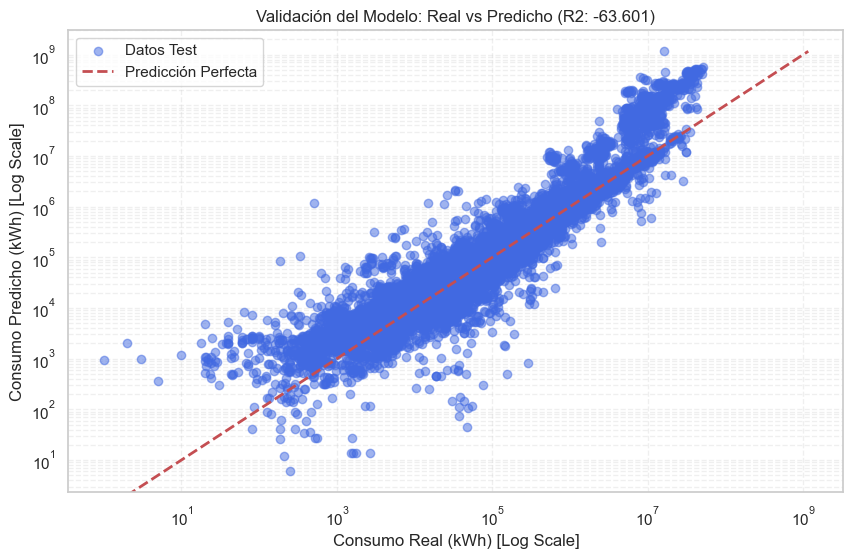

In [19]:
# 1. Generar predicciones unitarias (kWh por cliente)
y_pred_unitario = model.predict(X_test)

# 2. Reconstruir el consumo TOTAL de la comuna (kWh Totales)
# Multiplicamos la predicción promedio por la cantidad de clientes de ese mes
y_pred_total = y_pred_unitario * X_test_clientes

# 3. Métricas de Negocio (Comparando Total Real vs Total Predicho)
# Usamos y_test_total_real que guardamos en el paso 2
r2_total = r2_score(y_test_total_real, y_pred_total)
mae_total = mean_absolute_error(y_test_total_real, y_pred_total)
mape_total = np.mean(np.abs((y_test_total_real - y_pred_total) / y_test_total_real)) * 100

print(f"--- Resultados de Negocio en Test Set ({fecha_corte} en adelante) ---")
print(f"R2 Score (Total): {r2_total:.4f} (Varianza explicada del consumo total)")
print(f"MAE (Total):      {mae_total:,.0f} kWh (Error promedio por comuna-mes)")
print(f"MAPE (Total):     {mape_total:.2f}% (Porcentaje de error en la facturación)")

# 4. Gráfico: Predicción vs Realidad (Escala Logarítmica)
plt.figure(figsize=(10, 6))

# Usamos log-log porque hay comunas gigantes (Maipú) y pequeñas (Alhué)
# Si no usamos log, las pequeñas se ven como una mancha en la esquina.
plt.scatter(y_test_total_real, y_pred_total, alpha=0.5, color='royalblue', label='Datos Test')

# Línea de perfección (Ideal)
min_val = min(y_test_total_real.min(), y_pred_total.min())
max_val = max(y_test_total_real.max(), y_pred_total.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Consumo Real (kWh) [Log Scale]")
plt.ylabel("Consumo Predicho (kWh) [Log Scale]")
plt.title(f"Validación del Modelo: Real vs Predicho (R2: {r2_total:.3f})")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.show()

## 5. Importancia de Variables
¿Qué factores pesan más en la decisión del modelo?

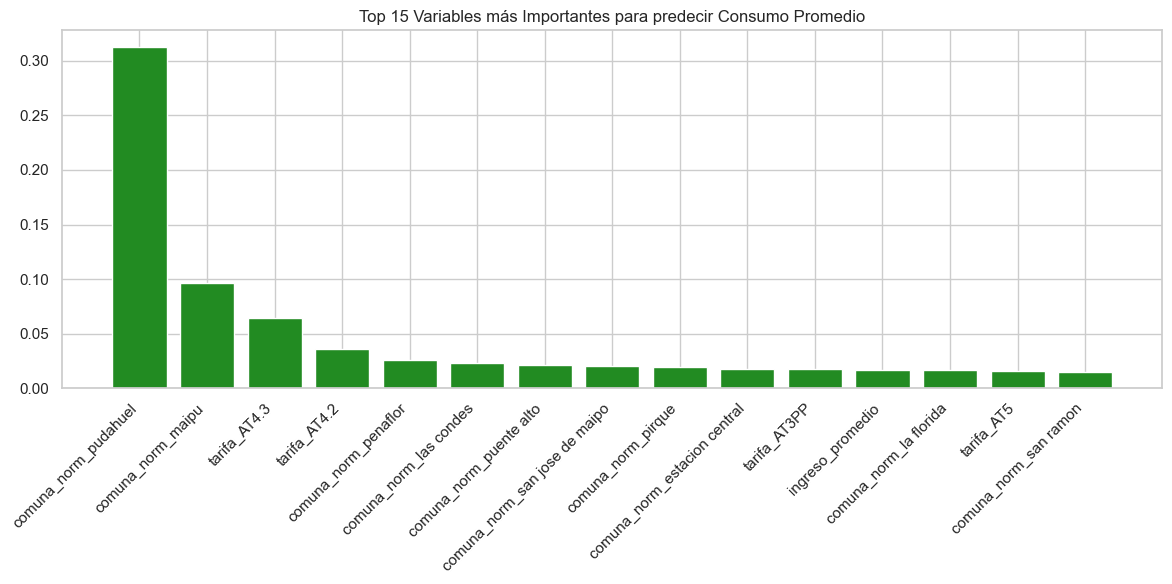


--- Nueva Interpretación (Modelo Normalizado) ---
1. ¿HDD (Frío) es el rey? Si 'hdd_acumulado' está #1, confirmas que la calefacción es el gran driver.
2. Socioeconómico: Si 'ingreso_promedio' o 'tasa_pobreza' están altos, hay desigualdad energética.
3. Ciclos: Si 'mes_cos' o 'mes_sin' aparecen, el modelo aprendió correctamente la estacionalidad.
4. Comunas: Si aparece una comuna específica (ej: 'comuna_norm_LasCondes'), es porque tiene un comportamiento único no explicado solo por su ingreso o clima.


In [20]:
# Calcular Importancia
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# --- VISUALIZACIÓN OPTIMIZADA ---
# Seleccionar solo las Top 15 para que el gráfico sea legible
# (Al usar One-Hot Encoding tenemos muchas columnas nuevas, mostrar todas ensuciaría el gráfico)
top_n = 15
top_indices = indices[:top_n]

plt.figure(figsize=(12, 6))
plt.title(f"Top {top_n} Variables más Importantes para predecir Consumo Promedio")
plt.bar(range(top_n), importances[top_indices], align="center", color='forestgreen')
plt.xticks(range(top_n), [features_final[i] for i in top_indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n--- Nueva Interpretación (Modelo Normalizado) ---")
print("1. ¿HDD (Frío) es el rey? Si 'hdd_acumulado' está #1, confirmas que la calefacción es el gran driver.")
print("2. Socioeconómico: Si 'ingreso_promedio' o 'tasa_pobreza' están altos, hay desigualdad energética.")
print("3. Ciclos: Si 'mes_cos' o 'mes_sin' aparecen, el modelo aprendió correctamente la estacionalidad.")
print("4. Comunas: Si aparece una comuna específica (ej: 'comuna_norm_LasCondes'), es porque tiene un comportamiento único no explicado solo por su ingreso o clima.")